In [1]:
import QuantLib as ql
import pandas as pd
import xlwings as xw

# 1. YieldTermStructure Handle

In [2]:
valDate = ql.Date(31,8,2025)
ql.Settings.instance().evaluationDate = valDate

In [3]:
r = 0.03
r_q = ql.SimpleQuote(r)


In [4]:
r_qh= ql.QuoteHandle(r_q)

In [5]:
riskfree_curve = ql.FlatForward(0,ql.SouthKorea(ql.SouthKorea.Settlement),r_qh,ql.ActualActual(ql.ActualActual.ISDA))

In [6]:
riskfree_curve

<QuantLib.QuantLib.FlatForward; proxy of <Swig Object of type 'ext::shared_ptr< FlatForward > *' at 0x00000178F2DD66D0> >

In [7]:
yld_handle = ql.YieldTermStructureHandle(riskfree_curve)

# 채권구성

In [8]:
issueDate = ql.Date(10,12,2024)
matDate = ql.Date(10,12,2027)
coupons = [2.875/100]
face_amt = 10000
cal = ql.SouthKorea()
bdc = ql.Following
settlement_days = 0
schedule = ql.Schedule(issueDate,matDate,ql.Period(ql.Semiannual),cal,ql.Following,ql.Following,ql.DateGeneration.Backward,False)
day_count = ql.ActualActual(ql.ActualActual.Bond)

In [9]:
fixbond = ql.FixedRateBond(settlement_days,face_amt,schedule,coupons,day_count)

# 3. 엔진의 구성

In [10]:
bond_engine = ql.DiscountingBondEngine(yld_handle)
fixbond.setPricingEngine(bond_engine)

# 4. 채권의 평가

In [11]:
fixbond.NPV()

10032.522586675248

In [12]:
fixbond.cleanPrice() / 100 * face_amt

9967.324499243552

In [13]:
fixbond.dirtyPrice() / 100 * face_amt

10032.522586675248

In [14]:
fixbond.accruedAmount() / 100 * face_amt

65.19808743169486

In [15]:
check = fixbond.NPV() -(fixbond.cleanPrice() / 100 * face_amt + fixbond.accruedAmount() / 100 * face_amt)
check

1.8189894035458565e-12

# 4.1 Yield Curve의 변경

In [16]:
riskfree_curve.discount(ql.Date(31,8,2025)+ql.Period(3,ql.Years))

0.9139810598137215

In [17]:
r_q.setValue(0.04)

In [18]:
riskfree_curve.discount(ql.Date(31,8,2025)+ql.Period(3,ql.Years))

0.8869849713401036

In [19]:
r_q.setValue(0.04)
riskfree_curve.discount(ql.Date(31,8,2025)+ql.Period(3,ql.Years))

0.8869849713401036

In [20]:
fixbond.NPV()

9813.881414976295

In [21]:
r_q.setValue(0.03)
fixbond.NPV()

10032.522586675248

## 4.2 평가일자의 변경

In [22]:
valDate1 = ql.Date(31,8,2026)
ql.Settings.instance().evaluationDate = valDate1

In [23]:
fixbond.NPV()

10045.583344984163

In [24]:
valDate = ql.Date(31,8,2025)
ql.Settings.instance().evaluationDate = valDate

## 4.3 현금흐름의 검증

In [25]:
data = []
for cf in fixbond.cashflows():
    cf1 = ql.as_fixed_rate_coupon(cf)
    if cf1 is not None:
        row = {"date": cf1.date().ISO(),
           "accrualStartDate": cf1.accrualStartDate().ISO(),
           "accrualEndDate": cf1.accrualEndDate().ISO(),
           "accrualDays": cf1.accrualDays(),
           "accrualPeriod": cf1.accrualPeriod(),
           "rate": cf1.rate(),
           "amount": cf1.amount(),
           "nominal": cf1.nominal(),
           "dayCounter": str(cf1.dayCounter()),
           "InterestRate": str(cf1.interestRate()),
           }
        data.append(row)
    else:
        row = {"date": cf.date().ISO(),
               "accrualStartDate": 0,
               "accrualEndDate": 0,
               "accrualDays": 0,
               "accrualPeriod": 0,
               "rate": 0,
               "amount":cf.amount(),
               "nominal": 0,
               "dayCounter": 0,
               "InterestRate": 0,
               }
    data.append(row)
df = pd.DataFrame(data)
df

,date,accrualStartDate,accrualEndDate,accrualDays,accrualPeriod,rate,amount,nominal,dayCounter,InterestRate
0,2025-06-10,2024-12-10,2025-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
1,2025-06-10,2024-12-10,2025-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
2,2025-12-10,2025-06-10,2025-12-10,183,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
3,2025-12-10,2025-06-10,2025-12-10,183,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
4,2026-06-10,2025-12-10,2026-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
5,2026-06-10,2025-12-10,2026-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
6,2026-12-10,2026-06-10,2026-12-10,183,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
7,2026-12-10,2026-06-10,2026-12-10,183,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
8,2027-06-10,2026-12-10,2027-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...
9,2027-06-10,2026-12-10,2027-06-10,182,0.5,0.02875,143.75,10000.0,Actual/Actual (ISMA) day counter,2.875000 % Actual/Actual (ISMA) simple compoun...


In [26]:
day_count.yearFraction(ql.Date(10,12,2024),ql.Date(10,6,2025))

0.5

In [27]:
data = []
for cf in fixbond.cashflows():
    row1 = {"date": cf.date().ISO(),
            "CFamount": cf.amount()}
    if cf.date() <= valDate:
        row1["yearFrac"] = 0
        row1["discfac"] = 0
    else:
        row1["yearFrac"] = day_count.yearFraction(valDate, cf.date())
        row1["discfac"] = riskfree_curve.discount(cf.date())


    row1["pv"] = row1["CFamount"] * row1["discfac"]
    data.append(row1)
df_pv = pd.DataFrame(data)
df_pv

,date,CFamount,yearFrac,discfac,pv
0,2025-06-10,143.75,0.00,0.000000,0.000000
1,2025-12-10,143.75,0.25,0.991815,142.573335
2,2026-06-10,143.75,0.75,0.977088,140.456467
3,2026-12-10,143.75,1.25,0.962502,138.359657
4,2027-06-10,143.75,1.75,0.948211,136.305351
5,2027-12-10,143.75,2.25,0.934056,134.270511
6,2027-12-10,10000.00,2.25,0.934056,9340.557266


In [28]:
df_pv.pv.sum() - fixbond.NPV()

np.float64(0.0)

# 5. 요소에 대한 설명

## Schedule

In [29]:
startDate = ql.Date(1,1,2025)
endDate = ql.Date(1,1,2026)
first_date = ql.Date(15, ql.January, 2025) 
last_date = ql.Date(15, ql.December, 2025) 
bcd = ql.Following

schedule_1 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Backward, False)
schedule_2 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Backward, False, first_date)
schedule_3 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Forward, False)
schedule_4 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Forward, False,ql.Date(),last_date)
list(schedule_1)

[Date(2,1,2025),
 Date(3,2,2025),
 Date(4,3,2025),
 Date(1,4,2025),
 Date(2,5,2025),
 Date(2,6,2025),
 Date(1,7,2025),
 Date(1,8,2025),
 Date(1,9,2025),
 Date(1,10,2025),
 Date(3,11,2025),
 Date(1,12,2025),
 Date(2,1,2026)]

In [30]:
temp_df_1,temp_df_2,temp_df_3, temp_df_4  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()

temp_df_1["schedule_1"] = list(schedule_1) # 1개월단위 following, Backward 
temp_df_2["schedule_2"] = list(schedule_2) # 1개월단위 following, Backward ,firstDate
temp_df_3["schedule_3"] = list(schedule_3) # 1개월단위 following, Forward 
temp_df_4["schedule_4"] = list(schedule_4) # 1개월단위 following, Forward 

temp_df = pd.concat([temp_df_1,temp_df_2,temp_df_3,temp_df_4],axis=1) # 1개월단위 following, forward 
temp_df

,schedule_1,schedule_2,schedule_3,schedule_4
0,"January 2nd, 2025","January 2nd, 2025","January 2nd, 2025","January 2nd, 2025"
1,"February 3rd, 2025","January 15th, 2025","February 3rd, 2025","February 3rd, 2025"
2,"March 4th, 2025","February 3rd, 2025","March 4th, 2025","March 4th, 2025"
3,"April 1st, 2025","March 4th, 2025","April 1st, 2025","April 1st, 2025"
4,"May 2nd, 2025","April 1st, 2025","May 2nd, 2025","May 2nd, 2025"
5,"June 2nd, 2025","May 2nd, 2025","June 2nd, 2025","June 2nd, 2025"
6,"July 1st, 2025","June 2nd, 2025","July 1st, 2025","July 1st, 2025"
7,"August 1st, 2025","July 1st, 2025","August 1st, 2025","August 1st, 2025"
8,"September 1st, 2025","August 1st, 2025","September 1st, 2025","September 1st, 2025"
9,"October 1st, 2025","September 1st, 2025","October 1st, 2025","October 1st, 2025"


In [31]:
tartDate = ql.Date(30,1,2025)
endDate = ql.Date(30,1,2026)
first_date = ql.Date(15, ql.February, 2025) 
last_date = ql.Date(15, ql.January, 2026) 
bcd = ql.ModifiedFollowing

schedule_1 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Backward, False)
schedule_2 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Backward, False, first_date)
schedule_3 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Forward, False)
schedule_4 = ql.Schedule(startDate,endDate,ql.Period(1,ql.Months),cal,bcd,bcd,ql.DateGeneration.Forward, False, ql.Date(),last_date)
list(schedule_1)
temp_df_1,temp_df_2,temp_df_3, temp_df_4  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()

temp_df_1["schedule_1"] = list(schedule_1) # 1개월단위 following, Backward 
temp_df_2["schedule_2"] = list(schedule_2) # 1개월단위 following, Backward ,firstDate
temp_df_3["schedule_3"] = list(schedule_3) # 1개월단위 following, Forward 
temp_df_4["schedule_4"] = list(schedule_4) # 1개월단위 following, Forward 

temp_df = pd.concat([temp_df_1,temp_df_2,temp_df_3,temp_df_4],axis=1) # 1개월단위 following, forward 
temp_df

,schedule_1,schedule_2,schedule_3,schedule_4
0,"January 2nd, 2025","January 2nd, 2025","January 2nd, 2025","January 2nd, 2025"
1,"January 31st, 2025","February 17th, 2025","February 3rd, 2025","February 3rd, 2025"
2,"February 28th, 2025","February 28th, 2025","March 4th, 2025","March 4th, 2025"
3,"March 31st, 2025","March 31st, 2025","April 1st, 2025","April 1st, 2025"
4,"April 30th, 2025","April 30th, 2025","May 2nd, 2025","May 2nd, 2025"
5,"May 30th, 2025","May 30th, 2025","June 2nd, 2025","June 2nd, 2025"
6,"June 30th, 2025","June 30th, 2025","July 1st, 2025","July 1st, 2025"
7,"July 30th, 2025","July 30th, 2025","August 1st, 2025","August 1st, 2025"
8,"August 29th, 2025","August 29th, 2025","September 1st, 2025","September 1st, 2025"
9,"September 30th, 2025","September 30th, 2025","October 1st, 2025","October 1st, 2025"


## Calendar에 대한 설명

In [32]:
cal = ql.SouthKorea()
cal_1 = ql.SouthKorea(ql.SouthKorea.Settlement)

In [33]:
date_lst = list(ql.MakeSchedule(ql.Date(15,12,2025),ql.Date(15,1,2026),ql.Period(1,ql.Days)))
len(date_lst)

32

In [34]:
for date_ in date_lst:
    is_business_day = cal.isBusinessDay(date_)
    is_business_day_1 = cal_1.isBusinessDay(date_)
    
    # 출력 포맷 지정 (ql.Date 객체를 문자열로 변환)
    date_str = date_.to_date().strftime("%Y-%m-%d (%a)")
    status = "영업일 (Business Day) ✅" if is_business_day else "휴일 (Holiday) ❌"
    status_1 = "영업일 (Business Day) ✅" if is_business_day_1 else "휴일 (Holiday) ❌"
    
    print(f"{date_str}: {status}, {status_1}")

2025-12-15 (Mon): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-16 (Tue): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-17 (Wed): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-18 (Thu): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-19 (Fri): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-20 (Sat): 휴일 (Holiday) ❌, 휴일 (Holiday) ❌
2025-12-21 (Sun): 휴일 (Holiday) ❌, 휴일 (Holiday) ❌
2025-12-22 (Mon): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-23 (Tue): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-24 (Wed): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-25 (Thu): 휴일 (Holiday) ❌, 휴일 (Holiday) ❌
2025-12-26 (Fri): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-27 (Sat): 휴일 (Holiday) ❌, 휴일 (Holiday) ❌
2025-12-28 (Sun): 휴일 (Holiday) ❌, 휴일 (Holiday) ❌
2025-12-29 (Mon): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-30 (Tue): 영업일 (Business Day) ✅, 영업일 (Business Day) ✅
2025-12-31 (Wed): 휴일 (Holiday) ❌, 영업일 (Business Day) ✅
2026-01-01 (Thu): 휴일 (Holiday

# 6. Yield Curve Handle의 변경

In [35]:
yld_hdl_1 = ql.RelinkableYieldTermStructureHandle(riskfree_curve)

In [36]:
bond_engine = ql.DiscountingBondEngine(yld_hdl_1)
fixbond.setPricingEngine(bond_engine)
fixbond.NPV()

10032.522586675248

In [37]:
def load_from_xls(xls:str,sht_nm:str,rng:str):
    app = xw.App(visible=False)
    try:
        wb_0 = xw.Book(xls)
        sht = wb_0.sheets[sht_nm]
        df = sht.range(rng).expand().options(pd.DataFrame,index=False).value
        wb_0.close()
    except:
        return 1
    #wb_0.close()
    app.kill()
    return df

In [38]:
df_ = load_from_xls("C:\work\youtube_lecture\lecture_0\FSS_IFRS17 및 K-ICS 금리기간구조(원화)__25.8.xlsm","원화 무위험 금리기간구조","AB12")

In [39]:
df_

,proj_month,Spot rate를 이용한 할인율
0,0.0,1.000000
1,1.0,0.998052
2,2.0,0.996106
3,3.0,0.994159
4,4.0,0.992213
...,...,...
1196,1196.0,0.077286
1197,1197.0,0.077118
1198,1198.0,0.076950
1199,1199.0,0.076783


In [40]:
ql_date_list = list(ql.MakeSchedule(ql.Date(31,8,2025),ql.Date(31,8,2125), ql.Period("1M"),endOfMonth=True))
discount_curve = ql.DiscountCurve(ql_date_list, df_.iloc[:,1], ql.ActualActual(ql.ActualActual.ISDA), ql.SouthKorea(ql.SouthKorea.Settlement),ql.LogLinear())

In [41]:
yld_hdl_1.linkTo(discount_curve)

In [42]:
fixbond.NPV()

10173.51934374786

# 7. Duration의 계산

In [43]:
clean_price = fixbond.cleanPrice()
ytm = fixbond.bondYield(clean_price,day_count,ql.Compounded,ql.Semiannual)

In [44]:
ytm_rate = ql.InterestRate(ytm, day_count, ql.Compounded, ql.Semiannual)

In [45]:
mac_duration = ql.BondFunctions.duration(
    fixbond,
    ytm_rate,
    ql.Duration.Modified
)
mac_duration 

2.1779511542287513

# 8. Spread의 반영

In [51]:
spread = ql.SimpleQuote(0.0)
discount_curve_1 = ql.ZeroSpreadedTermStructure(ql.RelinkableYieldTermStructureHandle(discount_curve),ql.QuoteHandle(spread))
yld_hdl_1.linkTo(discount_curve_1)
npv_base=fixbond.NPV()

## Effective Duration의 계산

In [52]:
spread.setValue(0.001)
npv_up = fixbond.NPV()
npv_up

10151.088916249904

In [53]:
spread.setValue(-0.001)
npv_dn = fixbond.NPV()
npv_dn

10196.000351927898

In [54]:
eff_dur =  (npv_dn - npv_up) / (2*npv_base * 0.001)
eff_dur

2.2072713561799078

# 9. 일자별 채권가격

In [55]:
valDate_lst = list(ql.MakeSchedule(valDate, matDate, ql.Period(1,ql.Days)))

In [58]:
data = []
date_lst = []
for date_ in valDate_lst:
    ql.Settings.instance().evaluationDate = date_
    date_lst.append(date_.to_date())
    ql_date_list = list(ql.MakeSchedule(date_,date_+ ql.Period(100,ql.Years), ql.Period("1M"),endOfMonth=True))
    discount_curve = ql.DiscountCurve(ql_date_list, df_.iloc[:,1], ql.ActualActual(ql.ActualActual.ISDA), ql.SouthKorea(ql.SouthKorea.Settlement),ql.LogLinear())
    yld_hdl_1.linkTo(discount_curve)
    data.append(fixbond.cleanPrice()/100*face_amt )


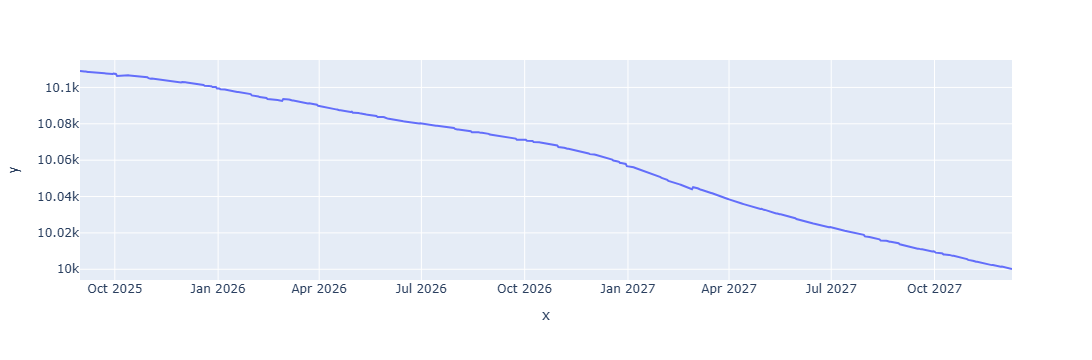

In [59]:
import plotly.express as px
fig = px.line(x=date_lst[:-1],y=data[:-1])
fig.show()